In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
tweets = pd.read_csv("stock_tweets.csv")
stocks = pd.read_csv("stock_yfinance_data.csv")

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

### Forecasting

In [55]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [56]:
stocks = pd.read_csv('stock_output.csv')

In [57]:
stocks_MSFT = stocks[stocks['Stock Name'] == 'MSFT']

*Visualize time series of stock*

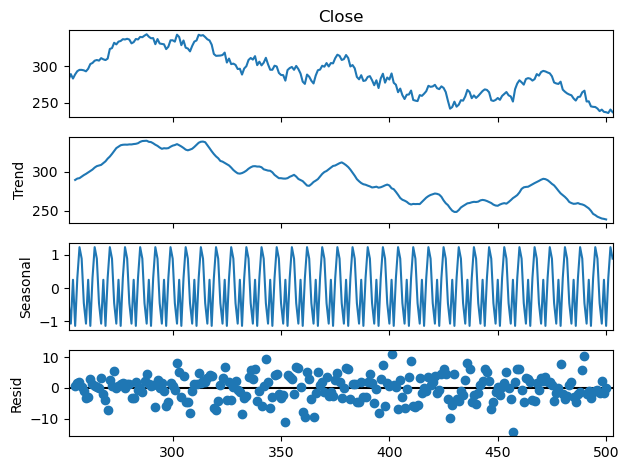

In [5]:
#decompose the stock price of Microsoft
result = seasonal_decompose(stocks_MSFT['Close'], model="additive", period=7)
result.plot();

*Determining Parameters*

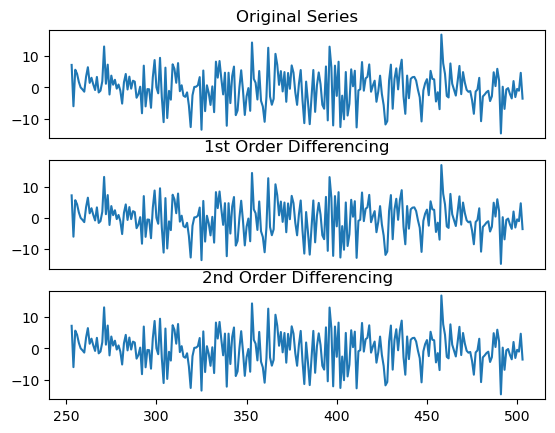

In [6]:
# Model time seres and different level of differencing
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(stocks_MSFT['Close'].diff()); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(stocks_MSFT['Close'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(stocks_MSFT['Close'].diff()); ax3.set_title('2nd Order Differencing')
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(stocks_MSFT['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation if stationary or not
if result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

ADF Statistic: -1.015255
p-value: 0.747660
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
The time series is not stationary.


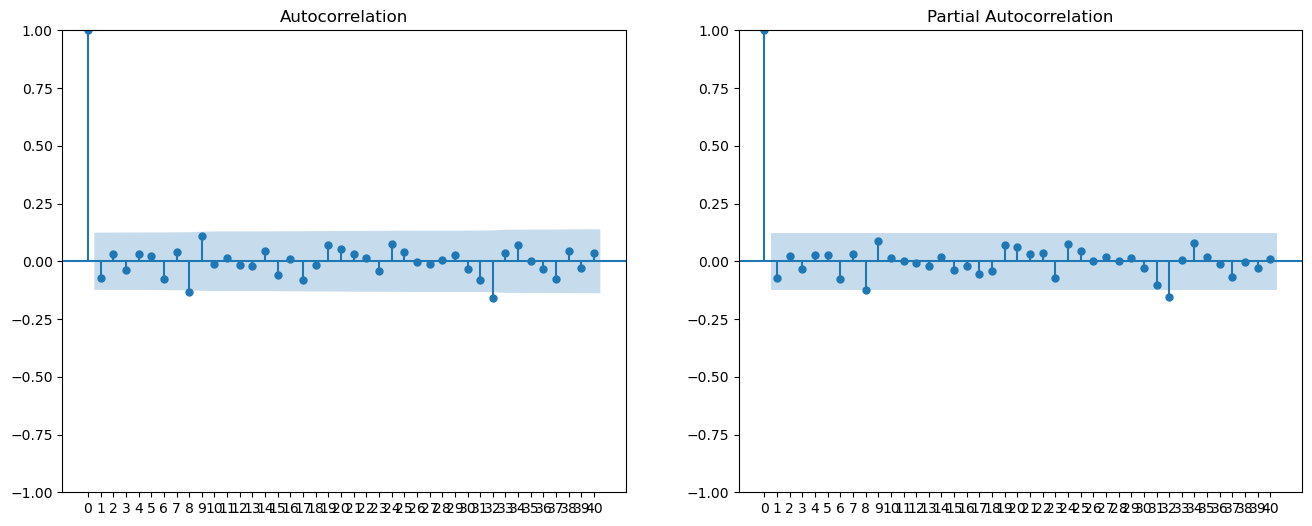

In [8]:
# Set up the figure and axis
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot autocorrelation
plot_acf(stocks_MSFT['Close'].diff().dropna(), lags=40, ax=ax[0])
ax[0].set_xticks(range(41))  # Set x-axis ticks manually for the first subplot

# Plot partial autocorrelation
plot_pacf(stocks_MSFT['Close'].diff().dropna(), lags=40, ax=ax[1])
ax[1].set_xticks(range(41))  # Set x-axis ticks manually for the second subplot

# Show the plot
plt.show()

*SARIMA Model*

In [58]:
import statsmodels.api as sm

#create SARIMA model
model = sm.tsa.statespace.SARIMAX(stocks_MSFT['Close'], order=(0, 1, 0), seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
arima_result = model.fit()

print(arima_result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  252
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -726.629
Date:                              Wed, 15 May 2024   AIC                           1459.259
Time:                                      04:34:27   BIC                           1469.521
Sample:                                           0   HQIC                          1463.400
                                              - 252                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0004      0.043     -0.009      0.993      -0.084       0.084
ma.S.L12      -1.00

In [59]:
# Make in-sample prediction
forecast = arima_result.predict(start=stocks_MSFT['Close'].index[0], end=stocks_MSFT['Close'].index[-1], typ='levels')

# first value is NaN due to differencing
observed = stocks_MSFT['Close'][1:]  # Skip the first NaN value
predicted = forecast[1:]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(observed, predicted))
print(f'RMSE: {rmse}')

RMSE: 77.77607598578791


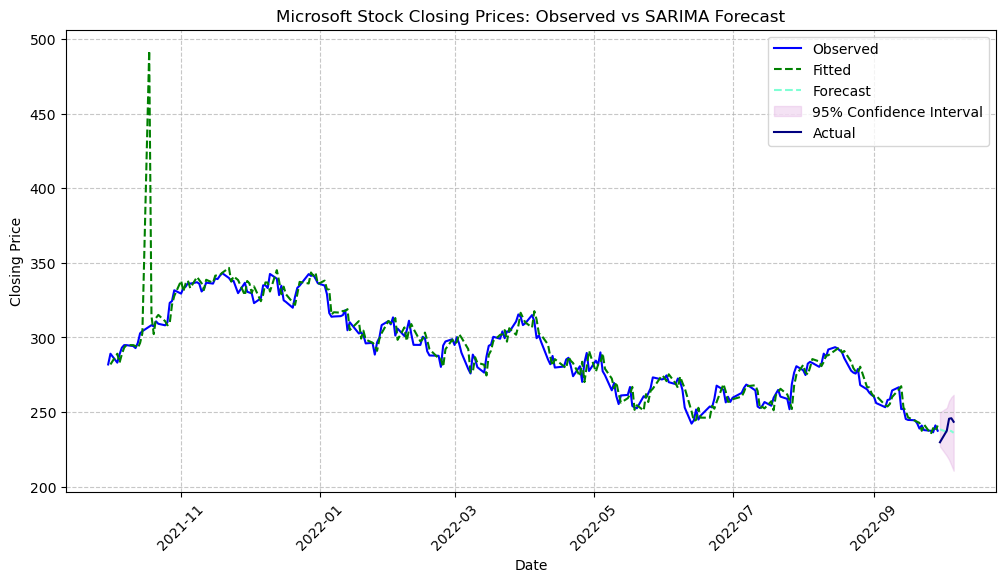

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

# Get in-sample fitted values
fitted_values = arima_result.predict(typ='levels')  # 'levels' for actual predictions

# Forecast future values (5 days)
forecast_steps = 5
forecast_result = arima_result.get_forecast(steps=forecast_steps)
forecast_values = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Ensures 'Date' is in datetime format and without timezone
stocks_MSFT['Date'] = pd.to_datetime(stocks_MSFT['Date']).dt.tz_localize(None)

# Extend the date range for forecasting
last_date = stocks_MSFT['Date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='B')[1:]

# Prepare forecast DataFrame
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecast_values,
    'Lower CI': conf_int.iloc[:, 0],
    'Upper CI': conf_int.iloc[:, 1]
})

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(stocks_MSFT['Date'], stocks_MSFT['Close'], label='Observed', color='blue')
plt.plot(stocks_MSFT['Date'].iloc[1:], fitted_values.iloc[1:], label='Fitted', color='green', linestyle='--')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', color='aquamarine', linestyle='--')
plt.fill_between(forecast_df['Date'], forecast_df['Lower CI'], forecast_df['Upper CI'], color='plum', alpha=0.3, label='95% Confidence Interval')

# Fetch and plot actual data
MSFT_data = yf.Ticker("MSFT")
actual_data = MSFT_data.history(start=forecast_dates[0], end=forecast_dates[-1] + pd.Timedelta(days=1))
actual_data.reset_index(inplace=True)
actual_data['Date'] = actual_data['Date'].dt.tz_localize(None)  # Ensure no timezone

# Merge and plot actual data
forecast_df = pd.merge(forecast_df, actual_data[['Date', 'Close']], on='Date', how='left')
forecast_df.rename(columns={'Close': 'Actual'}, inplace=True)
plt.plot(forecast_df['Date'], forecast_df['Actual'], label='Actual', color='navy')

plt.xticks(rotation=45)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Microsoft Stock Closing Prices: Observed vs SARIMA Forecast')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()

In [61]:
#print forecast
forecast_df_base = forecast_df
forecast_df_base

,Date,Forecast,Lower CI,Upper CI,Actual
0,2022-09-30,238.387952,227.005144,249.770760,229.779358
1,2022-10-03,236.728059,220.639463,252.816655,237.514313
2,2022-10-04,237.722470,218.021771,257.423169,245.545258
3,2022-10-05,237.218245,214.471989,259.964500,245.860962
4,2022-10-06,236.131308,210.701664,261.560951,243.483261


In [62]:
from sklearn.metrics import mean_squared_error

# Ensures forecast and actual data align properly for the RMSE calculation
aligned_data = forecast_df.dropna(subset=['Actual', 'Forecast'])

# Calculate the RMSE of forecast and actual
mse = mean_squared_error(aligned_data['Actual'], aligned_data['Forecast'])
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE) of the Forecast vs Actual: {rmse:.4f}")

Root Mean Squared Error (RMSE) of the Forecast vs Actual: 7.2756


### Using sentiment analysis

In [73]:
import statsmodels.api as sm

# Create SARIMAX model
order = (0, 1, 0)  
model = sm.tsa.statespace.SARIMAX(stocks_MSFT['Close'], 
                                  exog = stocks_MSFT['Average_sentiment'],
                                  order=(0, 1, 0), 
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

# Fit the model
results = model.fit()

# Summary of the model
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                  252
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -726.563
Date:                              Wed, 15 May 2024   AIC                           1461.125
Time:                                      05:14:27   BIC                           1474.807
Sample:                                           0   HQIC                          1466.647
                                              - 252                                         
Covariance Type:                                opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Average_sentiment    -0.4834      1.252     -0.386      0.699      -2.938       1.97

In [74]:
# Use the last observed sentiment for the next 5 periods forecast
last_sentiment = stocks_MSFT['Average_sentiment'].iloc[-1]
forecast_horizon = 5  # Next 5 steps
future_sentiments = np.full(shape=(forecast_horizon,), fill_value=last_sentiment)

# Forecasting
forecast = results.get_forecast(steps=forecast_horizon, exog=future_sentiments)
forecast_df = forecast.summary_frame()

print(forecast_df)

Close        mean    mean_se  mean_ci_lower  mean_ci_upper
252    238.364774   5.806011     226.985202     249.744345
253    236.704443   8.206284     220.620422     252.788465
254    237.699208  10.048703     218.004112     257.394305
255    237.198533  11.602146     214.458746     259.938321
256    236.117132  12.970857     210.694720     261.539544


In [75]:
# Fetch and plot actual data
MSFT_data = yf.Ticker("MSFT")
actual_data = MSFT_data.history(start=forecast_dates[0], end=forecast_dates[-1] + pd.Timedelta(days=1))
actual_data.reset_index(inplace=True)
actual_data['Date'] = actual_data['Date'].dt.tz_localize(None)  # Ensure no timezone

In [76]:
forecast_values = forecast_df['mean']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_data['Close'], forecast_values))
print("RMSE:", rmse)

RMSE: 7.283176150321833


In [77]:
# Resetting index 
base = forecast_df_base['Forecast'].reset_index(drop=True)
score_X = forecast_df['mean'].reset_index(drop=True)

# Making sure they have the same length and calcukate similarity between SARIMA and SARIMAX
if len(base) == len(score_X):
    distance = (base - score_X).abs()
else:
    raise ValueError("The series do not have the same length.")

distance

0    0.023178
1    0.023616
2    0.023262
3    0.019711
4    0.014176
dtype: float64

*Rolling Average*

In [70]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Rolling average of 5 previous days
stocks_MSFT['SMA_5_sentiment'] = stocks_MSFT['Average_sentiment'].rolling(window=5).mean()

# Fill any NaN values that arise due to rolling mean calculation
stocks_MSFT['SMA_5_sentiment'].fillna(method='bfill', inplace=True)  # Backfill or another appropriate method

# Model fitting, using the SMA_5_sentiment as the exogenous variable
model = SARIMAX(stocks_MSFT['Close'], exog=stocks_MSFT['SMA_5_sentiment'], order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()

# Forecasting based 5 recent days
last_5_sentiments = stocks_MSFT['SMA_5_sentiment'].iloc[-1]
future_sentiments = np.full(shape=(forecast_horizon,), fill_value=last_5_sentiments)
forecast = results.get_forecast(steps=forecast_horizon, exog=future_sentiments)
forecast_df = forecast.summary_frame()

print(forecast_df)

Close        mean    mean_se  mean_ci_lower  mean_ci_upper
252    238.399087   5.721137     227.185864     249.612310
253    236.853607   8.086311     221.004728     252.702486
254    237.889053   9.901790     218.481901     257.296206
255    237.375834  11.432518     214.968510     259.783157
256    236.308504  12.781216     211.257780     261.359228


In [71]:
forecast_values = forecast_df['mean']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_data['Close'], forecast_values))
print("RMSE:", rmse)

RMSE: 7.16698364963824


In [72]:
# Resetting index 
base = forecast_df_base['Forecast'].reset_index(drop=True)
score_X = forecast_df['mean'].reset_index(drop=True)

# Making sure they have the same length and calcukate similarity between SARIMA and SARIMAX
if len(base) == len(score_X):
    distance = (base - score_X).abs()
else:
    raise ValueError("The series do not have the same length.")

distance

0    0.011136
1    0.125548
2    0.166583
3    0.157589
4    0.177196
dtype: float64

Only changed the variable names and variables neccassary for the Microsoft part of foecasting.